# Dataset visualization

Visualize the dataset

## Preprocess and load data

In [2]:
import datetime
import io
import os
import pickle

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from src.data.preprocess_data import DatasetManager

# S3 bucket
import boto3
from dotenv import dotenv_values

Define constants to be used later. *DRIVE_PATH* and *MODEL_PATH* should be the root path of project and path for models, respectively

In [4]:
EMOTION_LIST = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
MODEL_PATH = "../models/"

# Set values
BATCH_SIZE = 8
VAL_SIZE = 0.2
TEST_SIZE = 0.2
N_EPOCHS = 100
INPUT_SIZE = 224
N_FEATURES = len(EMOTION_LIST)

Load all of the data

In [5]:
dataset_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=None, 
                        test_transform=None)
data = dataset_manager.load_dataloaders(return_raw_data=True)

In [26]:
X_train, X_test, X_val = [x[1] for x in data['X'].items()]
y_train, y_test, y_val = [x[1] for x in data['y'].items()]
X_all = np.vstack([X_train, X_test, X_val])
y_all = np.vstack([y_train[:, None], y_test[:, None], y_val[:, None]]).squeeze()

## Visualize data distribution

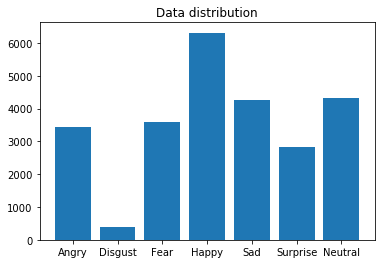

In [40]:
y_hist = np.histogram(y_all, bins=N_FEATURES)[0]
plt.title("Data distribution")
plt.bar(EMOTION_LIST, y_hist)
plt.savefig('../reports/figures/full_data_distribution.png')

It seems that data is quite highly imbalanced. Class disgust has very few instances. Let's take sample images from the classes.

In [43]:
class_indices = [np.where(y_all == i)[0][0] for i in range(N_FEATURES)]

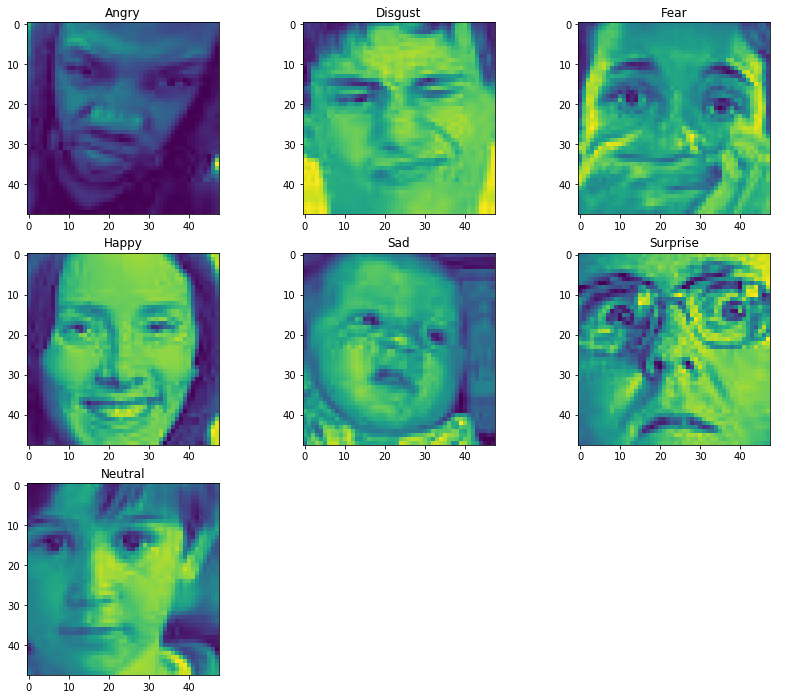

In [53]:
fig, ax = plt.subplots(3, 3, figsize=(14,12))
i = 0
j = 0
for category, indice in enumerate(class_indices):
    ax[i, j].set_title(EMOTION_LIST[category])
    ax[i, j].imshow(X_all[indice])
    
    if j < 2:
        j += 1
    else:
        i += 1
        j = 0
        
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.savefig('../reports/figures/emotion_samples.png')

#### Resnet-50

In [6]:
RESNET_NAME = 'resnet-50.pt'

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 2048),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(1024,  N_FEATURES)
)

checkpoint = torch.load(MODEL_PATH + RESNET_NAME, map_location=torch.device('cpu'))
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Traditional models

In [7]:
cnn_root_folder = MODEL_PATH + 'cnn_features/'
hog_root_folder = MODEL_PATH + 'hog_features/'
pca_root_folder = MODEL_PATH + 'pca_features/'

cnn_models = [pickle.load(open(cnn_root_folder + name, 'rb')) for name in os.listdir(cnn_root_folder)]
hog_models = [pickle.load(open(hog_root_folder + name, 'rb')) for name in os.listdir(hog_root_folder)]
pca_models = [pickle.load(open(pca_root_folder + name, 'rb')) for name in os.listdir(pca_root_folder)]

C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using versio

## View the performance of Resnet-50

For evaluation we need test dataloader

In [8]:
_, test_loader, _ = torch_manager.load_dataloaders()


We are going to visualize the performance with the help of Lime explainer. 

In [9]:
from lime import lime_image

In [10]:
explainer = lime_image.LimeImageExplainer()

Lime doesn't work with pytorch out of the box, because it expects numpy array. We need to create our own batch generator function which processes the image.

In [ ]:
def batch_to_single_image(batch):
    
    
def batch_predict(image):
    logits = resnet(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [ ]:
images_batch, labels_batch = next(iter(test_loader))

In [ ]:
single_image = 
single_label = labels_batch[0]
explanation = explainer.explain_instance(single_image, batch_predict, num_features=50, num_samples=400)